In [46]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer# Import TF IDF 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from typing import List 
import math
import re

In [2]:
df = pd.read_csv('mail_data.csv')
print(df.head())

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [62]:
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1}) # Turn spam and ham tag to 1 and 0 respactively

In [4]:
df.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Implement TF-IDF

In [48]:
def compute_tfidf(documents):
    # 1. Tokenize and clean a document
    def tokenize(doc):
        doc = re.sub(r'[\t\n\r]', ' ', doc)                 # Replace tabs/newlines
        doc = re.sub(r'[^\w\s]', '', doc.lower())           # Remove punctuation and lowercase
        doc = re.sub(r'\s+', ' ', doc).strip()              # Normalize whitespace
        return doc.split()                                  # Tokenize by splitting words

    # 2. Tokenize all documents
    tokenized_docs = [tokenize(doc) for doc in documents]

    # 3. Build vocabulary
    vocab = sorted(set(word for doc in tokenized_docs for word in doc))

    # 4. Compute Term Frequency (TF)
    def compute_tf(doc_tokens):
        tf = {}
        total_terms = len(doc_tokens)
        if total_terms == 0:
            return {word: 0 for word in vocab}
        for word in vocab:
            tf[word] = doc_tokens.count(word) / total_terms
        return tf

    tf_list = [compute_tf(doc) for doc in tokenized_docs]

    # 5. Compute Document Frequency (DF)
    def compute_df(docs):
        df = {}
        for word in vocab:
            df[word] = sum(1 for doc in docs if word in doc)
        return df

    df = compute_df(tokenized_docs)

    # 6. Compute Inverse Document Frequency (IDF)
    def compute_idf(df, N):
        idf = {}
        for word, doc_count in df.items():
            idf[word] = math.log(N / (1 + doc_count))
        return idf

    idf = compute_idf(df, len(documents))

    # 7. Compute TF-IDF for each document
    def compute_tfidf_vector(tf, idf):
        tfidf = {}
        for word in vocab:
            tfidf[word] = tf.get(word, 0) * idf.get(word, 0)
        return tfidf

    tfidf_list = [compute_tfidf_vector(tf, idf) for tf in tf_list]

    # 8. Round and clean up result
    result = []
    for tfidf in tfidf_list:
        result.append({word: round(score, 4) for word, score in tfidf.items() if score > 0})

    # 9. Turn list of dicts into matrix
    def tfidf_to_matrix(result, vocab):
        vocab_index = {word: idx for idx, word in enumerate(vocab)}
        matrix = np.zeros((len(result), len(vocab)))

        for doc_idx, tfidf_dict in enumerate(result):
            for word, tfidf in tfidf_dict.items():
                if word in vocab_index:
                    word_idx = vocab_index[word]
                    matrix[doc_idx][word_idx] = tfidf

        return matrix
    
    matrix =  tfidf_to_matrix(result, vocab)

    return matrix


In [57]:
dataset = compute_tfidf(df['Message'])

# Implement TF-IDF using scikit-learn
1. Using data(a list of sentence)
2. Convert these text documents into numerical vectors
    - Represent how important each word is in that document
    - Based on its frequency(TF) and inverse document frequency(IDF)
3. `fit()` the data
    - Scans the text data and creates a dictionary of all word `TfidfVectorizer()`
    - Calculate how rare or common each word is across all documents(IDF) `.fit(documents)`
4. `transform()` the data(application step)
    - Convert the input documents into a numerical matrix base on the vocabulary and  IDF that were learned during `fit()`

In [36]:
scikitlearn_data = df['Message'].dropna().astype(str) # Remove missing row
# Create the vectorizer
scikitlearn_data = scikitlearn_data.str.lower().replace(r'[^\w\s]','',regex=True)
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform text
tfidf_matrix = vectorizer.fit_transform(scikitlearn_data)

In [ ]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

print(tfidf_matrix[0])

# Implement Logistic regression


In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

    

In [23]:
def compute_loss(x_train, y_train, w, b):
    m = x_train.shape[0]
    z = np.dot(x_train, w) + b
    h = sigmoid(z)
    epsilon = 1e-15
    loss = -np.mean(y_train * np.log(h + epsilon) + (1 - y_train) *  np.log(1 - h + epsilon))
    return loss

In [21]:
def compute_gradient(x_train, y_train, w, b):
    m = x_train.shape[0]
    z = np.dot(x_train, w) + b
    h = sigmoid(z)
    error = h - y_train
    dw = np.dot(x_train.T, error) / m
    db = np.sum(error) / m
    return dw, db

def gradient_descent(x_train, y_train, w, b, iters, lr):
    losses = []
    for i in range(iters):
        dw_dj, db_dj = compute_gradient(x_train, y_train, w, b)
        w = w - lr*dw_dj
        b = b - lr*db_dj
        loss = compute_loss(x_train, y_train, w, b)
        losses.append(loss)
        if i % math.ceil(iters / 10) == 0:
            print(f"Iteration: {i}, Cost value: {compute_loss(x_train, y_train, w, b)}")

    print("Complete gradient descent!")
    print(f"Weight: {w}, Bias: {b}\n")

    return w, b, losses

    

In [15]:
def check_threshold(x, threshold):
    if x < threshold:
        return 0
    else:
        return 1

In [58]:
X = dataset # Taken from function compute_tfidf()
y = np.array(df['Category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
iters = 10000
lr_1 = 0.01


m,n = X_train.shape
w_1 = np.zeros(n,)
b_1 = 0


w_1, b_1, loss_1 = gradient_descent(X_train, y_train, w_1, b_1, iters, lr_1)

Iteration: 0, Cost value: 0.6917698229501618
Iteration: 1000, Cost value: 0.3973526189635055
Iteration: 2000, Cost value: 0.38445490294125917
Iteration: 3000, Cost value: 0.3794840859741482
Iteration: 4000, Cost value: 0.3751333234050555
Iteration: 5000, Cost value: 0.3708971221503404
Iteration: 6000, Cost value: 0.36673145368222404
Iteration: 7000, Cost value: 0.36263166572609196
Iteration: 8000, Cost value: 0.3585966960138447
Iteration: 9000, Cost value: 0.354625832969232
Complete gradient descent!
Weight: [ 0.01478585  0.00952728  0.0052442  ... -0.00446129 -0.15805026
 -0.00854035], Bias: -1.7624358685777506



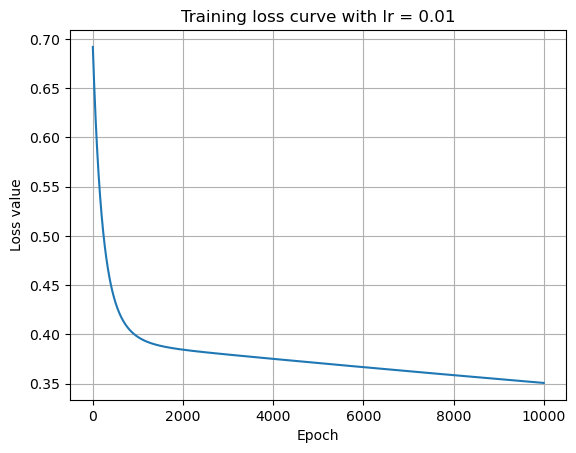

In [67]:
plt.plot(loss_1)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.title('Training loss curve with lr = 0.01')
plt.grid(True)
plt.show()

In [60]:
lr_2 = 0.5
m,n = X_train.shape
w_2 = np.zeros(n,)
b_2 = 0
w_2, b_2, loss_2 = gradient_descent(X_train, y_train, w_2, b_2, iters, lr_2)

Iteration: 0, Cost value: 0.6285775629198289
Iteration: 1000, Cost value: 0.2382303182060204
Iteration: 2000, Cost value: 0.1710247507126263
Iteration: 3000, Cost value: 0.13632622449535295
Iteration: 4000, Cost value: 0.11512313305761043
Iteration: 5000, Cost value: 0.10065400522140247
Iteration: 6000, Cost value: 0.09003196065504103
Iteration: 7000, Cost value: 0.0818270964294495
Iteration: 8000, Cost value: 0.07524944383632519
Iteration: 9000, Cost value: 0.0698255451497677
Complete gradient descent!
Weight: [ 0.35914476  0.24676946  0.10086805 ... -0.18617818 -1.76648286
 -0.10699855], Bias: -1.9435333345819052



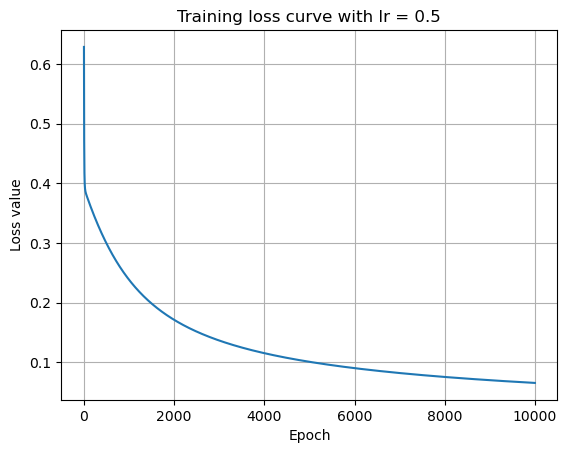

In [68]:
plt.plot(loss_2)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.title('Training loss curve with lr = 0.5')
plt.grid(True)
plt.show()

In [61]:
lr_3 = 0.1
m,n = X_train.shape
w_3 = np.zeros(n,)
b_3 = 0
w_3, b_3, loss_3 = gradient_descent(X_train, y_train, w_3, b_3, iters, lr_3)

Iteration: 0, Cost value: 0.679531725366098
Iteration: 1000, Cost value: 0.3506818645981168
Iteration: 2000, Cost value: 0.31495940832401054
Iteration: 3000, Cost value: 0.2848387755097646
Iteration: 4000, Cost value: 0.25955666227987134
Iteration: 5000, Cost value: 0.23832430785334505
Iteration: 6000, Cost value: 0.22041206984015044
Iteration: 7000, Cost value: 0.2051942305761004
Iteration: 8000, Cost value: 0.19215797011831212
Iteration: 9000, Cost value: 0.18089309103304704
Complete gradient descent!
Weight: [ 0.12570969  0.08316605  0.04118474 ... -0.04440059 -0.87835981
 -0.05123909], Bias: -1.697096462944613



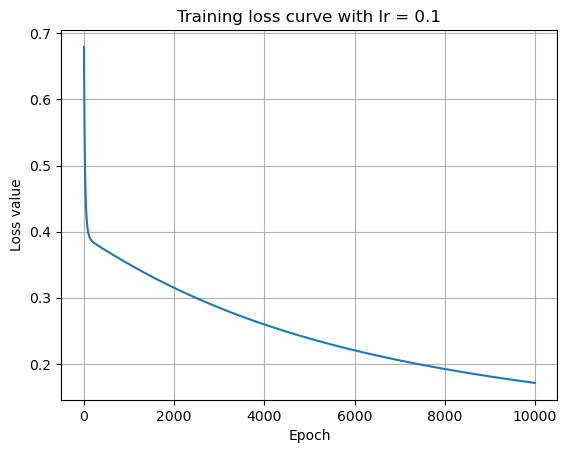

In [69]:
plt.plot(loss_3)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.title('Training loss curve with lr = 0.1')
plt.grid(True)
plt.show()

In [45]:
# Using sklearn logistic regression
X_sklearn = tfidf_matrix
y = np.array(df['Category'])

X_train_sklearn, X_test_sklearn, y_train, y_test = train_test_split(X_sklearn, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=50)
model.fit(X_train, y_train)

y_pred = model.predict(X_test_sklearn)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.95695067264574


# Confusion matrix

In [81]:
y_true = y_test
y_pred_1 = sigmoid(np.dot(X_test, w_1)+b_1)
y_pred_2 = sigmoid(np.dot(X_test, w_2)+b_2)
y_pred_3 = sigmoid(np.dot(X_test, w_3)+b_3)

# Applying the threshold to convert sigmoid outputs into binary (0 or 1)
y_pred_1_binary = (y_pred_1 >= 0.5).astype(int)
y_pred_2_binary = (y_pred_2 >= 0.5).astype(int)
y_pred_3_binary = (y_pred_3 >= 0.5).astype(int)

y_pred_binary = [y_pred_1_binary, y_pred_2_binary, y_pred_3_binary]


In [82]:
for i in range(len(y_pred_binary)):
    print(f"Confusion matrix {i+1}: \n {confusion_matrix(y_true, y_pred_binary[i])}")

Confusion matrix 1: 
 [[966   0]
 [149   0]]
Confusion matrix 2: 
 [[963   3]
 [ 26 123]]
Confusion matrix 3: 
 [[964   2]
 [ 67  82]]


In [ ]:
cm1 = confusion_matrix(y_true, y_pred_1)
cm2 = confusion_matrix(y_true, y_pred_2)
cm3 = confusion_matrix(y_true, y_pred_3)